# Comparison of the custom back tester with BackTrader
Let's implement the logic of the selected configuration of the strategy using BackTrader API https://backtrader.com. It will help us to verify the results of backtesting.

In [5]:
import sys
sys.path.append('../')

from Strategy import Strategy
import backtrader as bt
import os
import numpy as np
from datetime import datetime
from pandas import Series
import matplotlib.pyplot as plt
from tools import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

## Run custom back tester over first 500 periods

In [6]:
bars_data = load_ohlc_data('../data/binance_1h')
prices_data = get_bar_value_for_all_tickers(bars_data, 'close')

final_strategy = LongShortTradingStrategy(prices_data.head(500), benchmark_ticker='BTCUSDT')
final_strategy.set_strategy_params(up_q=0.07, down_q=0.07, max_t_in_pos=1)
final_strategy.run(log_trades=True)

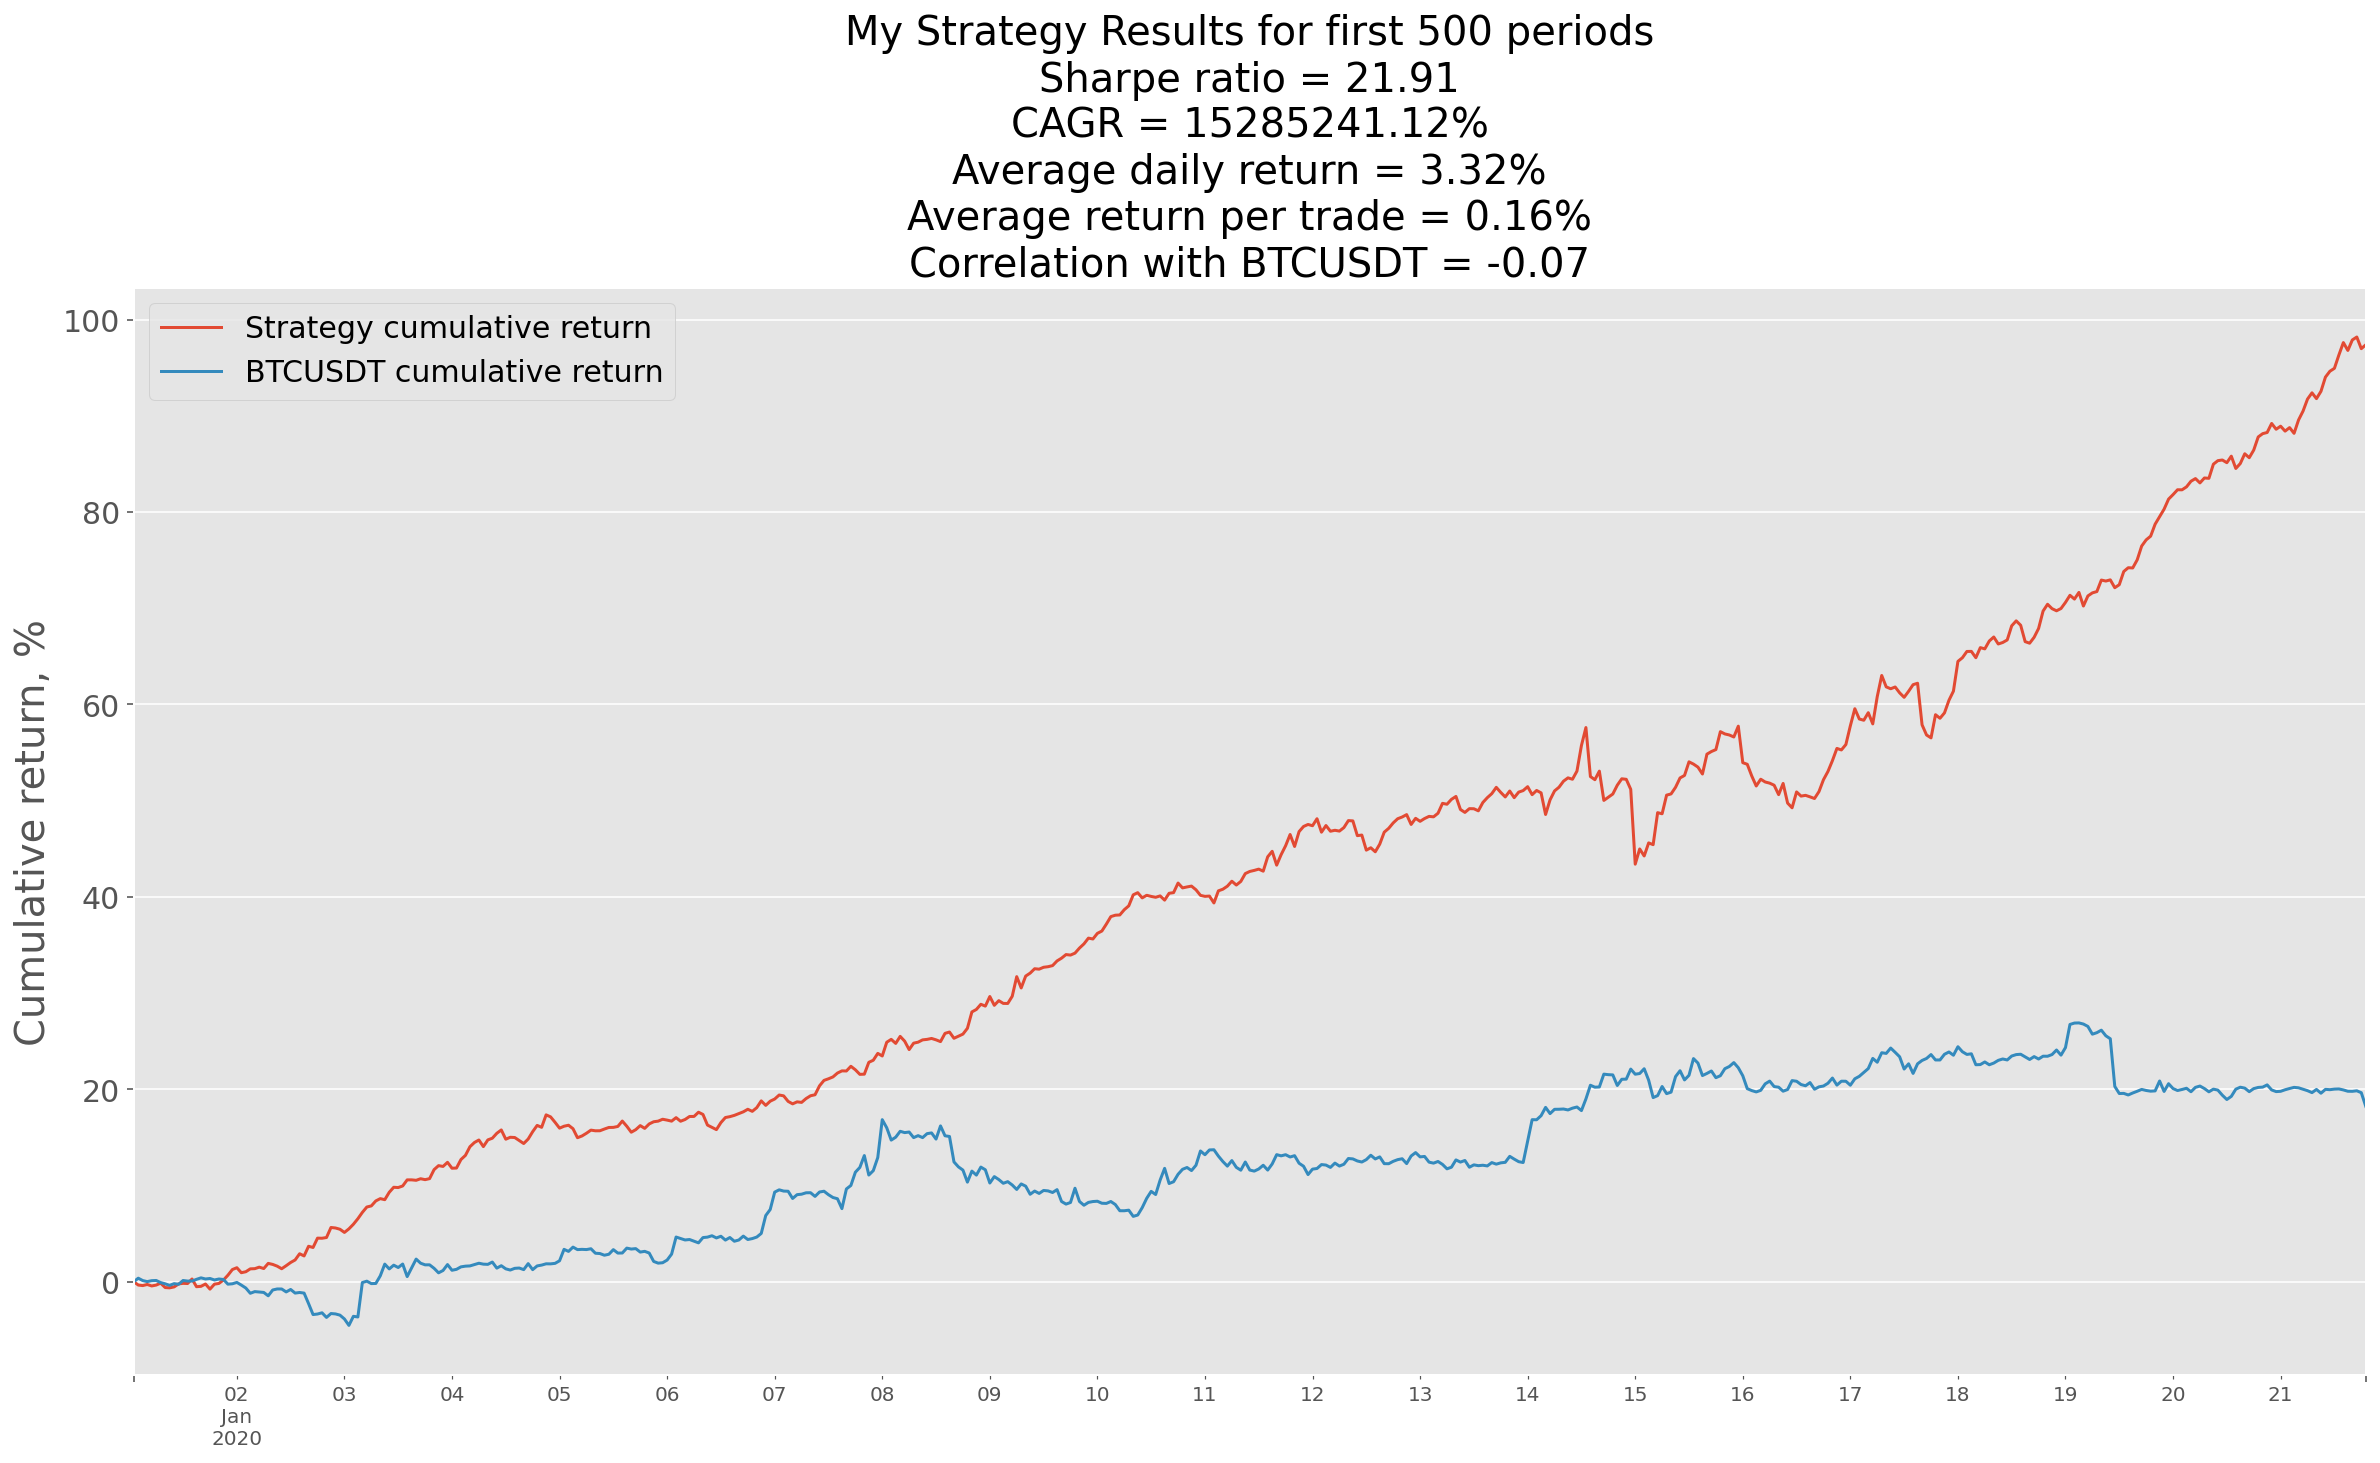

In [3]:
plot_strategy_results(final_strategy, 'My Strategy Results for first 500 periods')

## Run BackTrader on the same period

In [ ]:
cerebro = bt.Cerebro()

# CSV files are processed to have explicit NaNs because BackTrader uses inner join logic for multiple dataframes
folder_path = 'binance_1h_processed'
for file_name in os.listdir(folder_path):
    ticker = file_name[:file_name.index('.')]
    data = bt.feeds.GenericCSVData(dataname=os.path.join(folder_path, file_name),
                                   name=ticker,
                                   nullvalue=np.nan,
                                   fromdate=datetime(2020, 1, 1, 0),
                                   todate=datetime(2020, 1, 21, 19),
                                   dtformat=('%Y-%m-%d %H:%M:%S'),
                                   timeframe=bt.TimeFrame.Minutes,
                                   compression=60,
                                   datetime=0,
                                   open=1,
                                   high=2,
                                   low=3,
                                   close=4,
                                   volume=5,
                                   time=-1,
                                   openinterest=-1)
    cerebro.adddata(data)

cerebro.addstrategy(Strategy)
cerebro.getbroker().setcash(1000000)
# cheat-on-close allows to open positions using current close price
cerebro.getbroker().set_coc(True)
# shortcash = False means that shorted cash is taken into account and substracted when a short position is opened
cerebro.getbroker().set_shortcash(False)
# checksubmit = False means that we don't check order for available amount of cache before they are executed
# Let's use this setting to reproduce custom backtesting results
# Then we will check whether we borrow smth or not using Gross Leverage indicator
cerebro.getbroker().set_checksubmit(False)

cerebro.addanalyzer(bt.analyzers.PyFolio)
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')

res = cerebro.run(cheat_on_close=True, preloaded=False)
returns1d, positions, transactions, gross_lev = res[0].analyzers.getbyname('pyfolio').get_pf_items()
returns1h = res[0].analyzers.getbyname('timereturn').get_analysis()

### The results are exactly the same!
### And Gross Leverage <= 1 for the whole period. Along with setting that takes shorted cash into account it means that we do not use extra leverage to open positions.

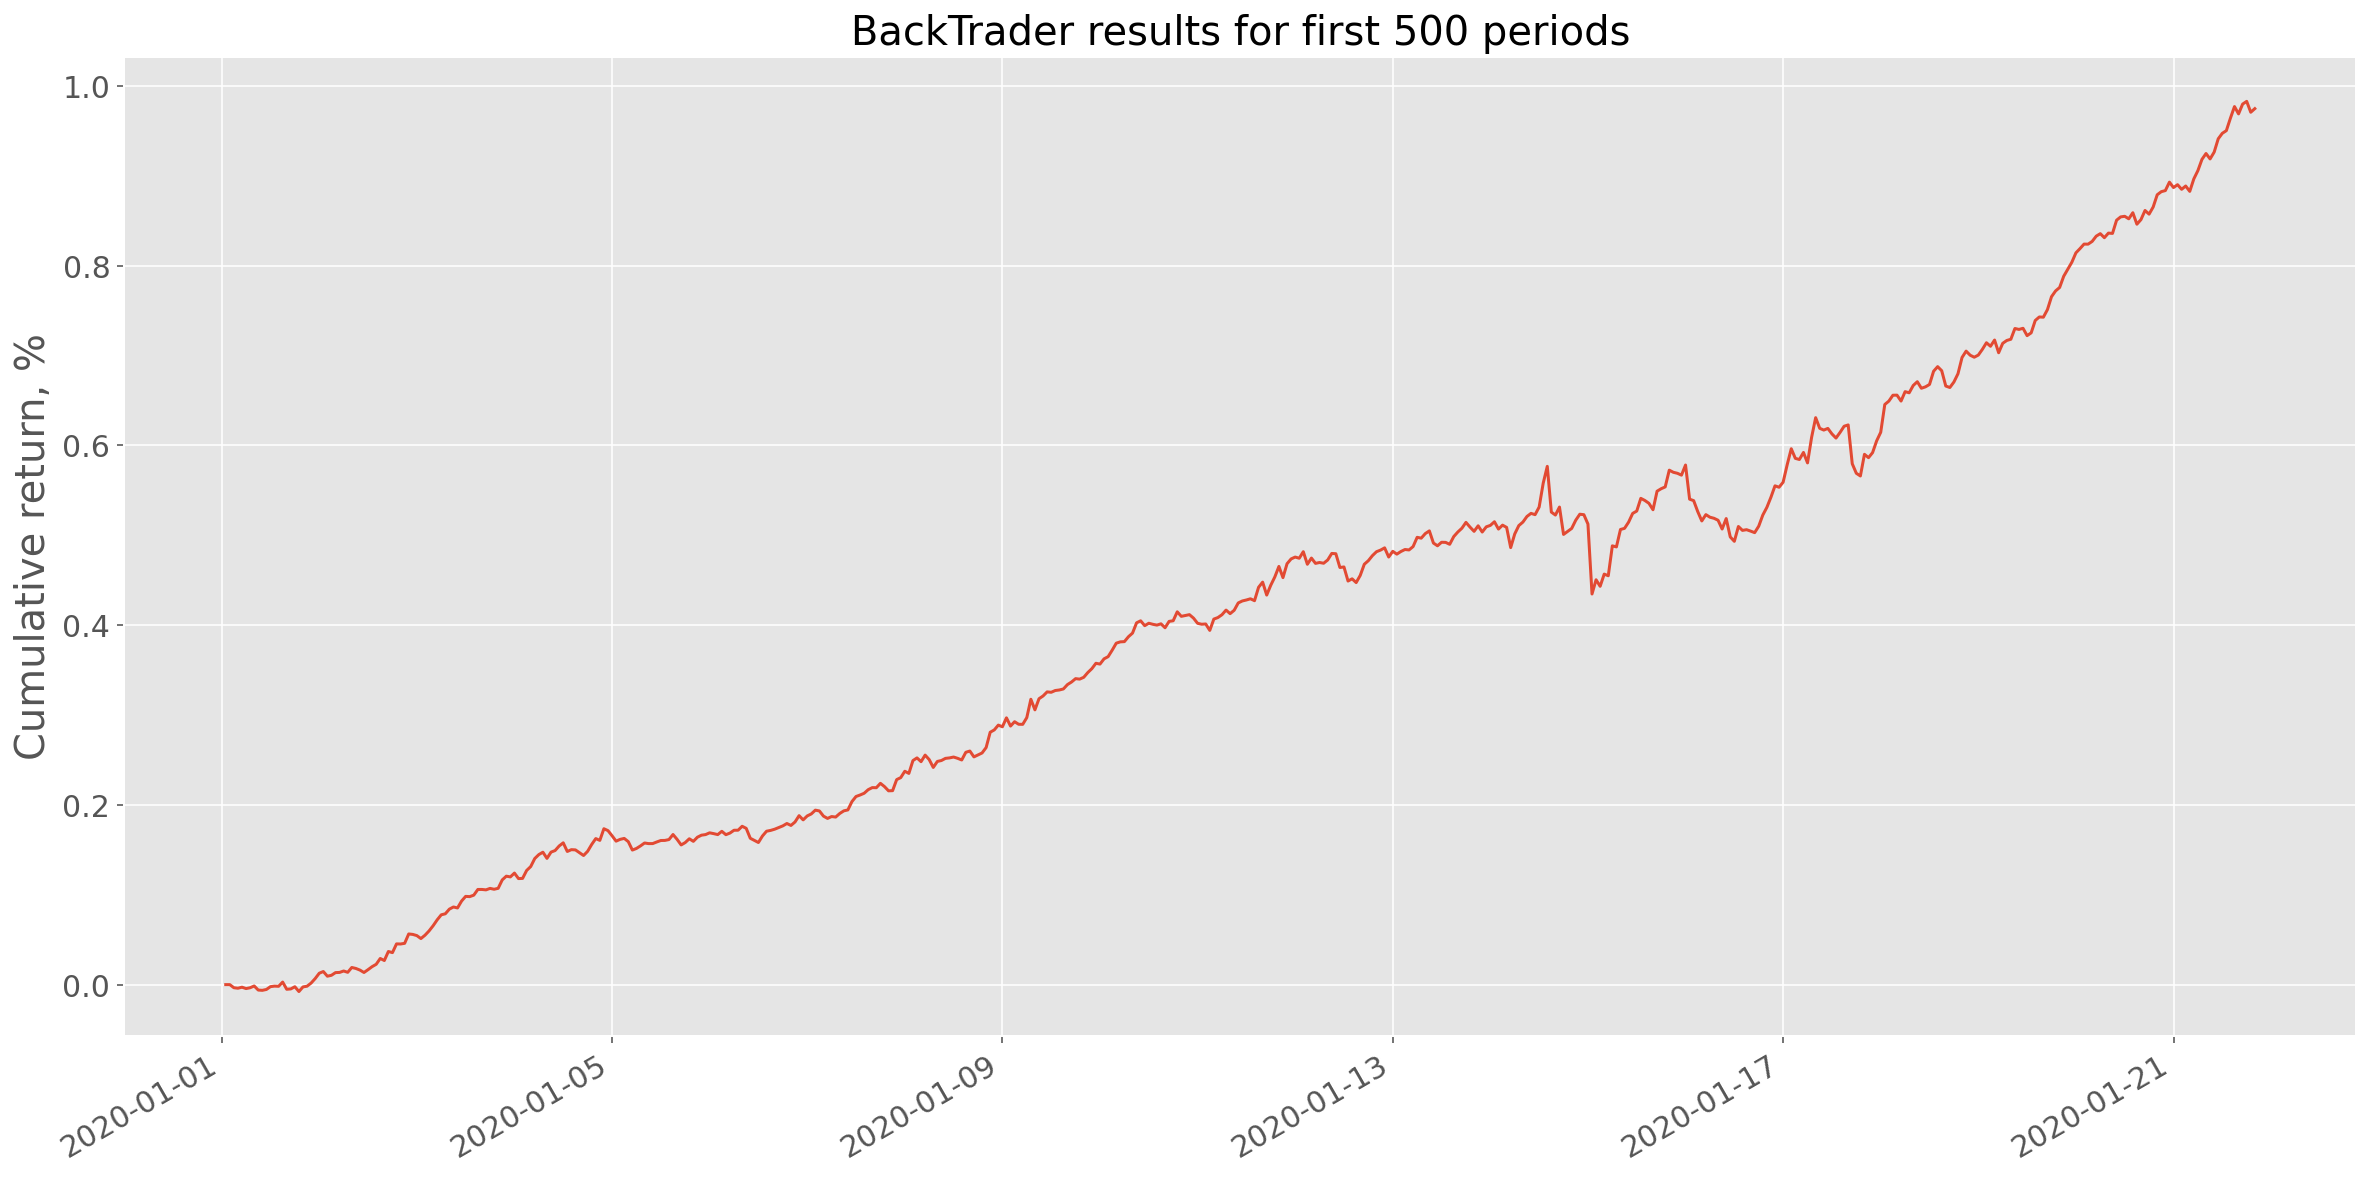

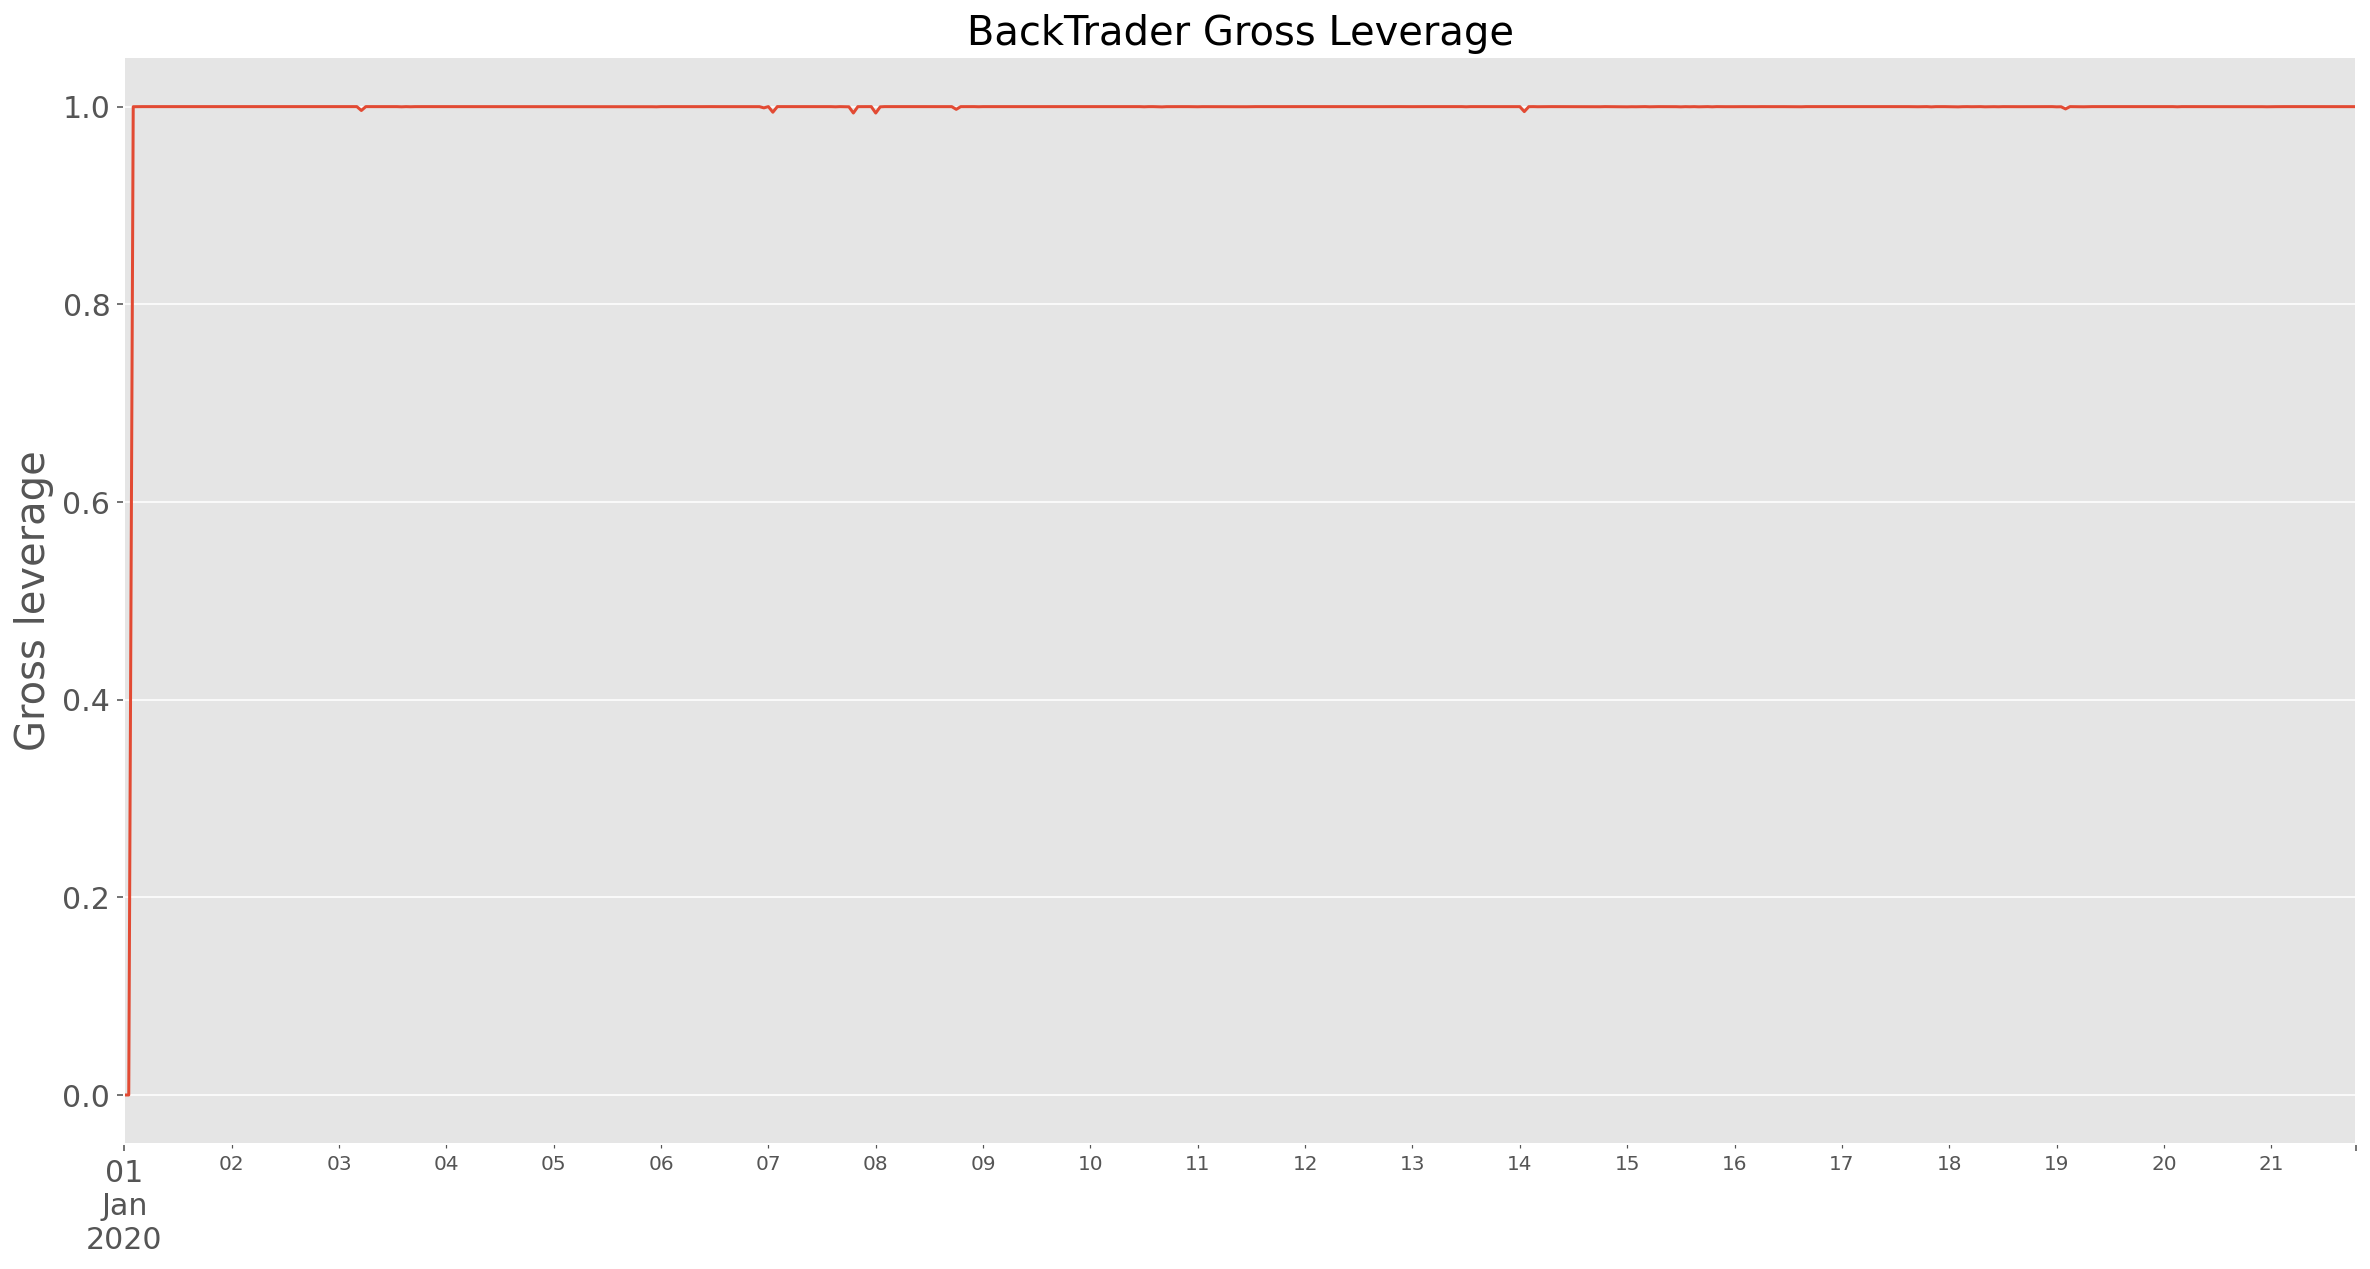

In [51]:
bt_cum_ret = (np.cumproduct(Series(returns1h) + 1) - 1)
bt_cum_ret.plot(figsize=(20, 10))
plt.xlabel('')
plt.ylabel('Cumulative return, %', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('BackTrader results for first 500 periods', size=20)
plt.show()

gross_lev.plot(figsize=(20, 10))
plt.xlabel('')
plt.ylabel('Gross leverage', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('BackTrader Gross Leverage', size=20)
plt.show()

## Run custom back tester over the whole sample

In [4]:
final_strategy = LongShortTradingStrategy(prices_data, benchmark_ticker='BTCUSDT')
final_strategy.set_strategy_params(up_q=0.07, down_q=0.07, max_t_in_pos=1)
final_strategy.run()

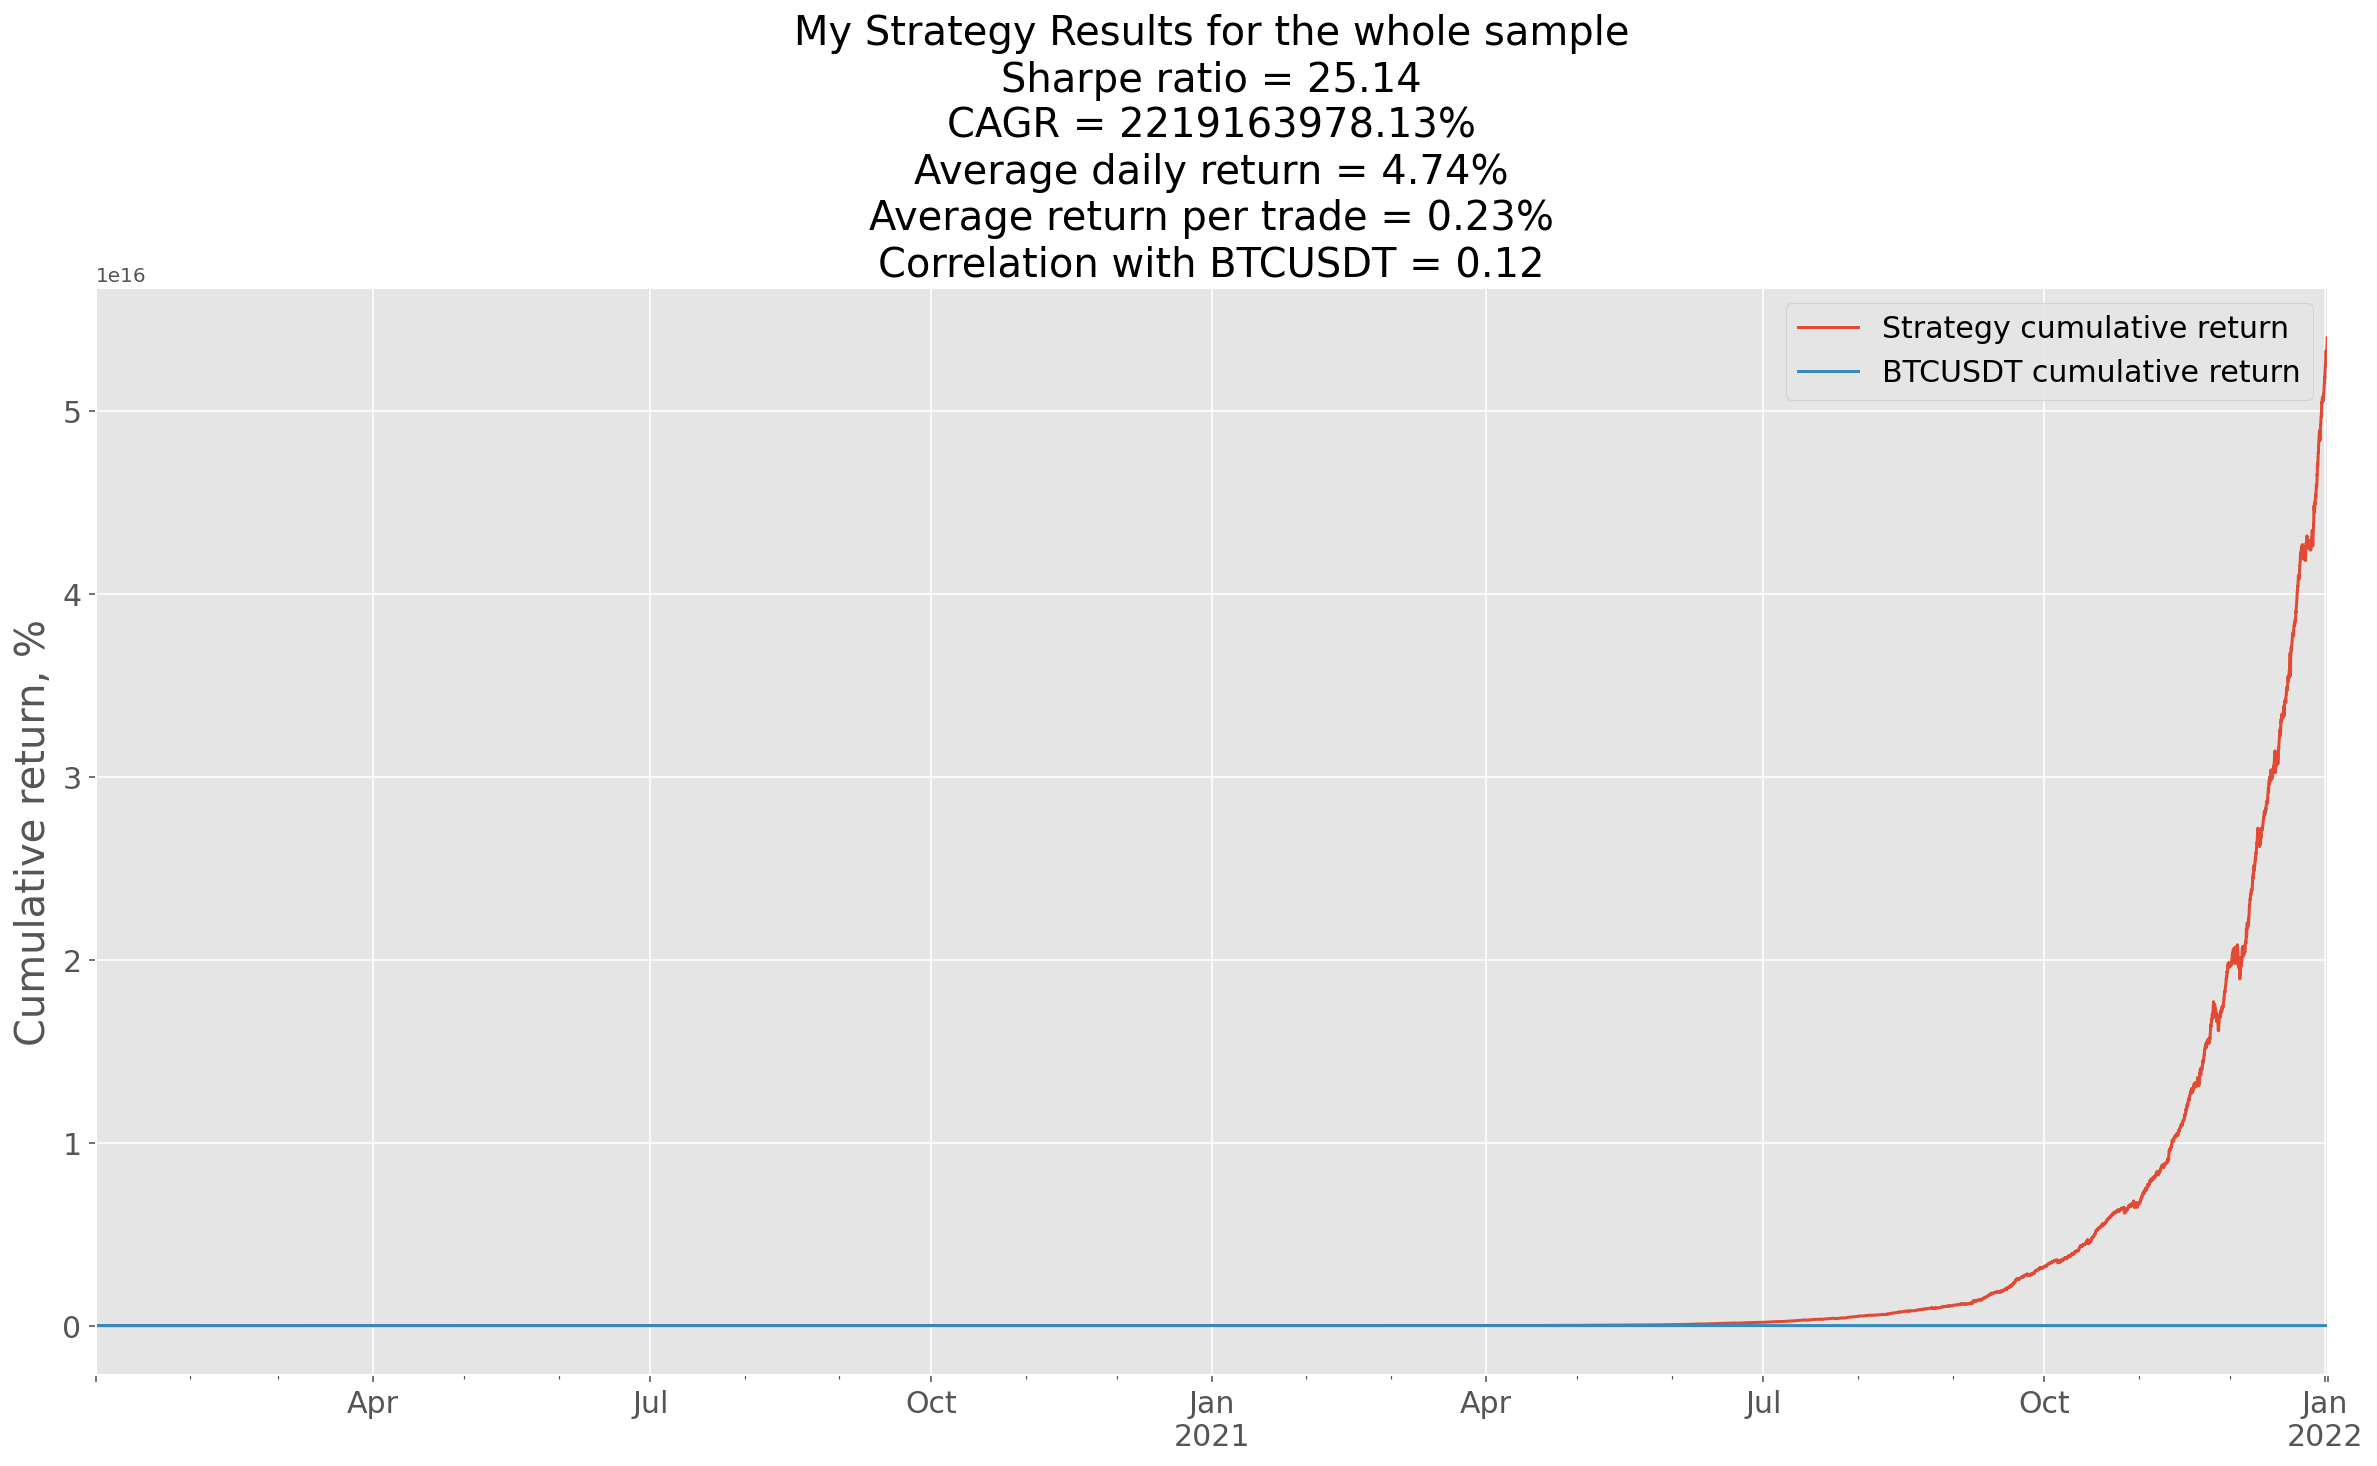

In [5]:
plot_strategy_results(final_strategy, 'My Strategy Results for the whole sample')

In [ ]:
cerebro = bt.Cerebro()

# CSV files are processed to have explicit NaNs because BackTrader uses inner join logic for multiple dataframes
folder_path = 'binance_1h_processed'
for file_name in os.listdir(folder_path):
    ticker = file_name[:file_name.index('.')]
    data = bt.feeds.GenericCSVData(dataname=os.path.join(folder_path, file_name),
                                   name=ticker,
                                   nullvalue=np.nan,
                                   dtformat=('%Y-%m-%d %H:%M:%S'),
                                   timeframe=bt.TimeFrame.Minutes,
                                   compression=60,
                                   datetime=0,
                                   open=1,
                                   high=2,
                                   low=3,
                                   close=4, 
                                   volume=5,
                                   time=-1,
                                   openinterest=-1)
    cerebro.adddata(data)

cerebro.addstrategy(Strategy)
cerebro.getbroker().setcash(1000000)
cerebro.getbroker().set_coc(True)

cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')

res = cerebro.run(cheat_on_close=True, preloaded=True)
returns1h = res[0].analyzers.getbyname('timereturn').get_analysis()

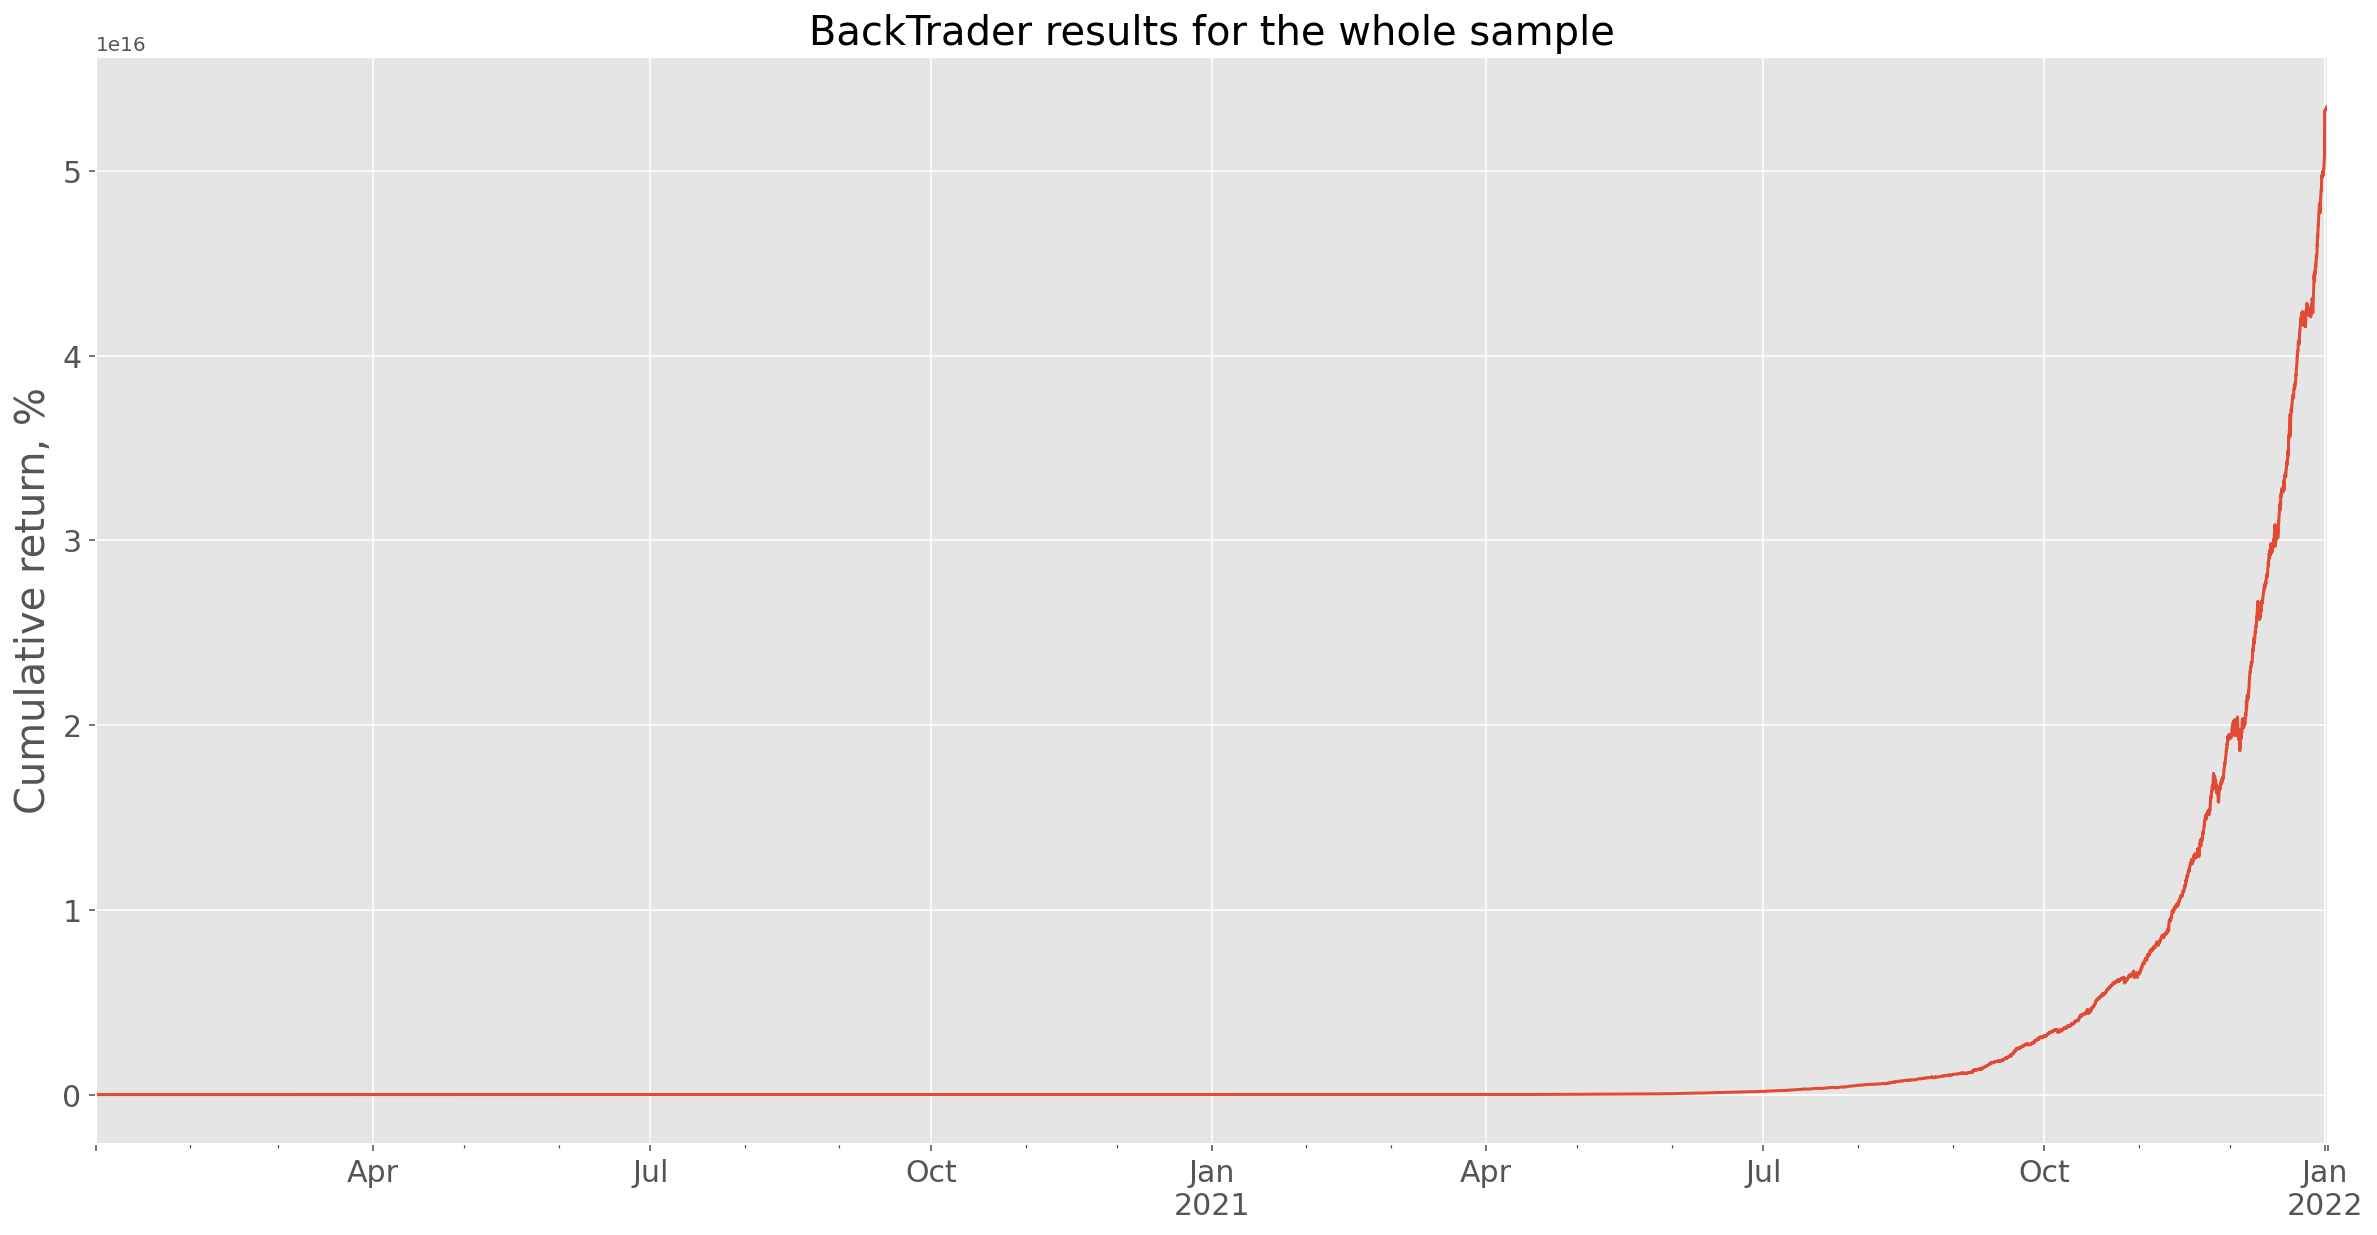

In [28]:
bt_cum_ret = (np.cumproduct(Series(returns1h) + 1) - 1) * 100
bt_cum_ret.plot(figsize=(20, 10))
plt.xlabel('')
plt.ylabel('Cumulative return, %', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('BackTrader results for the whole sample', size=20)
plt.show()